<a href="https://colab.research.google.com/github/hariprasathmurugesan/ColabSheets/blob/main/05_transfer_learning_with_tensorflow_part2_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Fine Tuning
We learnt feature extraction where the model which was copied over was used as is. One thing with feature learning is you need less training data. In our scenario we used only 10 percent training data and were able to get 98 percent accuracy

With **Fine Tuning** transfer learning we will need a larger dataset. We will unfreeze few of the layers from the imported/ copied over model and leave few layers unchanged

## Helper Functions Import

The functions which we wrote earlier like prep load image, plot loss curves etc

We can copy over those functions into a github notebook and get those in 2 steps

1. wget the raw file as shown below
2. once loaded, use the from command to pick whichever functions we need to use

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-10-27 12:18:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-27 12:18:08 (157 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some data
This time we can see how we can use the In-Build models in "tf.keras.applications" and apply them to our own problem (recognizing images of food)

In [ ]:
# Get 10% data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-10-27 12:18:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.4MB/s    in 8.5s    

2025-10-27 12:18:23 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and sub-directories

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Create train and test dir paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

## Image Dataset from Directory
Image Dataset from Directory - creates a tf.data.dataset . Has following advantages

1. As a dataset - its handy
2. Faster processing
3. We do not need to create the DATAGEN anymore. Everything in one hit

Changes from ImageDataGenerator
1. We basically type in the command+flow from directory together as
image_dataset_from_directory
2. We use image_size instead of target size
3. We use label_mode instead of class mode

In [ ]:
import tensorflow as tf

# Global Variables
IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Image Dataset from Directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Lets see how the dataset variable looks like
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Its a "Dataset" element with shape (None, 224, 224, 3)

None -> Batch size. Should be 32, but its always None
224, 224, 3 -> Image parameters

Tensor Spec Element -> (None, 10)
10 classes which are one hot encoded - Labels

Basically the data is loaded into batches with 2 tuples

Images and Labels

The "take" command can take batch by batch data and show it

In [ ]:
# Class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Take
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.39500000e+02 1.23357147e+02 6.25714264e+01]
   [1.35994888e+02 1.07755096e+02 5.25204048e+01]
   [1.39785706e+02 1.01637749e+02 5.10102005e+01]
   ...
   [2.05719482e+02 8.57194901e+01 1.32148010e+02]
   [2.03454132e+02 8.23112564e+01 1.27239815e+02]
   [2.17790787e+02 9.12499466e+01 1.34846848e+02]]

  [[1.44556122e+02 1.15984695e+02 6.33418388e+01]
   [1.04249992e+02 6.76836624e+01 2.32448883e+01]
   [9.65918350e+01 5.65663223e+01 1.99795895e+01]
   ...
   [1.84382660e+02 6.82959213e+01 1.13739754e+02]
   [1.85290863e+02 6.19489555e+01 1.08071426e+02]
   [2.03826874e+02 7.16380615e+01 1.19760445e+02]]

  [[1.32040802e+02 9.54693832e+01 5.36122398e+01]
   [9.62806091e+01 5.83928528e+01 2.76377544e+01]
   [8.36938705e+01 4.76530609e+01 2.60306110e+01]
   ...
   [1.72729248e+02 6.05098190e+01 1.04678146e+02]
   [1.73780609e+02 5.02090797e+01 9.74234009e+01]
   [1.79097290e+02 4.21533203e+01 9.25870361e+01]]

  ...

  [[8.54388885e+01 5.85919380e+01 2.87960339e+01]
   [9

If we see above, the shape is (32,224,224,3) for the first tuple which are basically the images in a batch

Second tuple is 32,10
has the one hot encoding label for the corresponding images

In [ ]:
len(train_data_10_percent)
24*32

# We have 24 batches of data and in each batch we have 32 images

768

## Keras Sequential (vs) Keras Functional API

Similarities in both : Compiling, Fitting and Evaluating

Differences : Model creation/ construction
In Fucntional API Model creation we define inputs, outputs, layers as x

Advantages of Functional API Model Creation
* Flexible
* Can produce sophisticated models

## Model 0 : Transfer Learning Model using Keras Functional API

The Sequential API which we created earlier is straight-forward, it runs the layers in Sequential order

But Functional API gives us more flexibility with our models

Steps in Creating the Baseline Model
1. Define base_model with tf.keras.applications.*, with parameter include_top. This variable base_model is for the model we are importing

2. Make sure the model is trainable or not

3. Define inputs with tf.keras.layers.Input

4. Rescale if needed with tf.keras.layers.preprocessing.rescaling(1/255.)(inputs)

5. Pass the inputs to the base model and introduce variable x, something like x = base_model(inputs)

6. Introduce GlobalAveragePooling2D layer with command tf.keras.layers.GlobalAveragePooling2D

7. Create the Output layer

8. Assign the inputs and outputs to the model, something like model_0 = tf.keras.Models(inputs, outputs)

### Create Compile Fit

In [ ]:
# Create a base model with tf.keras.applications
# include_top is given False, we can provide our own input layer
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze base model(so that underlying weights/ patterns can be made use of)
base_model.trainable = False

# Create inputs to our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

# We can rescale the data here. For Efficientnet we do not need to rescale,
# If using ResnetV2 - rescaling is needed and we can use the below layer for that
# We are commenting out as we are using efficientnet
# x = tf.keras.layers.experimental.preprocessing.rescaling(1/255.)(inputs)

# Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing the inputs to the base model : {x.shape}")

# Average Pool the outputs of the base model (aggregate the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after passing through GlobalAvgPoolLayer : {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Combine inputs and outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model and save to history variable
# Validating only 25 percent of test data
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks=create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name = "model_0"))


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing the inputs to the base model : (None, 7, 7, 1280)
Shape after passing through GlobalAvgPoolLayer : (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20251024-155357
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2918 - loss: 2.1169 - val_accuracy: 0.7352 - val_loss: 1.3415
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7128 - loss: 1.2529 - val_accuracy: 0.7977 - val_loss: 0.9124
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8022 - loss: 0.9076 - val_accuracy: 0.8405 - val_loss: 0.7418
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8302 - loss: 0.7299 - val_accuracy: 0.8618 - val_loss: 0.6169
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8579 - loss: 0.6405 - val_accuracy: 0.8717 - val_loss: 0.5625


The shape of the model when passing first is (None,7,7,1280) but after passing thru GlobalAveragePooling the shape gets condensed to (None, 1280) - Feature Vector

In [ ]:
# Evaluate on full test data set. When fitting, we did on 25 percent test data
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8622 - loss: 0.5646


[0.5736382603645325, 0.8555999994277954]

### Understanding Model Summaries

In [ ]:
# Layers in the EfficientNet model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

14

In [ ]:
# Summary of Base Model Efficient Net
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Summary of model_0
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

### Plot Loss Curves

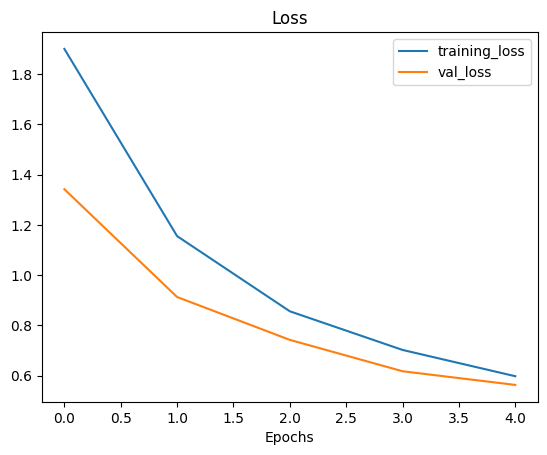

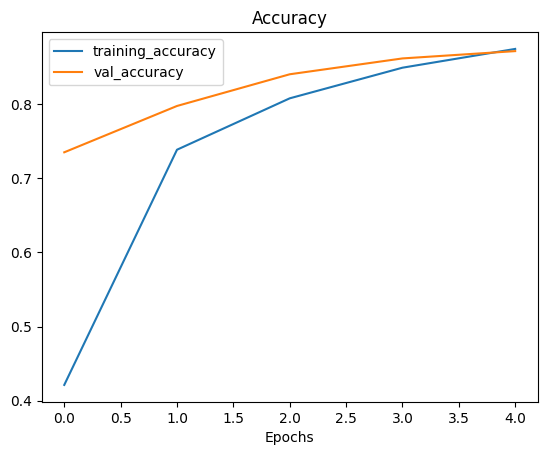

In [ ]:
# Check out curves
plot_loss_curves(history_10_percent)

### Feature Vector

Let's demostrate the GlobalAveragePooling2D
How the condensation happens and what a feature vector

GlobalAveragePooling2D transforms a 4D tensor to a 2D tensor

In our case (None,7,7,1280) to (None,1280)

lets do with an example of our own

In [ ]:
# Lets create a random tensor with shape 1,4,4,3
# 3 records in each row, 4 in each set, 4 sets, 1 in total which is outermost brackets
input_shape = (1,4,4,3)

input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor :\n{input_tensor}\n Tensor shape : {input_tensor.shape}")

Random Input Tensor :
[[[[-0.9573613  -0.22310454  0.6077782 ]
   [ 0.47778532 -1.4521011   2.1473675 ]
   [ 0.5301976   3.1052904  -0.36826396]
   [-0.21624118 -1.5030671   0.21273084]]

  [[ 0.32225537  1.1552492  -0.19488782]
   [ 0.15580721  0.73590565 -0.9312668 ]
   [-0.79003227 -1.5466045  -1.198435  ]
   [ 0.29848722  0.9593252   0.23790893]]

  [[ 0.48571467  0.209604   -0.13382818]
   [-1.6805025  -0.10056566  0.49550137]
   [ 0.510137    1.3832949   1.6169108 ]
   [ 0.4888768  -0.02216076 -1.0785509 ]]

  [[-1.2282875  -0.8910843  -0.0560388 ]
   [ 0.89735     0.23714669 -0.5724207 ]
   [ 0.11706991  1.2063016   0.31705084]
   [-1.6823026  -1.1284688   0.09762491]]]]
 Tensor shape : (1, 4, 4, 3)


In [ ]:
# Lets pass the random tensor into the GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Tensor : \n {global_average_pooled_tensor} \n Shape : {global_average_pooled_tensor.shape}")

2D Global Average Pooled Tensor : 
 [[-0.14194039  0.13281006  0.07494882]] 
 Shape : (1, 3)


Basically what the G.Avg.Pool2D does is, it get the mean values from the axis 1 and 2 (total axis are 0,1,2,3) and gives it to us

In [ ]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.14194039,  0.13281006,  0.07494882]], dtype=float32)>

✅ This is what is called as Feature extraction. By passing the inputs thru the efficientnet model (base_model) and then into GlobalAvgPool2D, the GlobalAvgPool2D extracts the features of the given image in a condensed format and provides to the output layer to train the output layer

In [ ]:
# Try GlobalMaxPool2D
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.89735  , 3.1052904, 2.1473675]], dtype=float32)>

## Running a series of transfer learning experiments

We have seen model_0 which is also transfer learning-feature extraction from efficientnet, we trained it with 10% data. Lets tweak input with 1% data

**Note** Throughout we will use the same test dataset

1. Model 1 - Feature Ext with 1% data + data augmentation

2. Model 2 - Feature Ext with 10% data + data augmentation

3. Model 3 - Fine tuning with 10% data + data augmentation

4. Model 4 - Fine tuning with 100% data + data augmentation

## Model 1 - Feature Extraction + 1% data + Aug

### Prepare Datasets

In [ ]:
# Download 1 percent data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2025-10-24 19:02:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   247MB/s    in 0.5s    

2025-10-24 19:02:40 (247 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
# Look at the data directories
walk_through_dir("10_food_1_percent_classes")

In [ ]:
# Set up train dir and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# Set up Datasets using ImageDatasetFromDirectory
import tensorflow as tf

# Define Global Variables
IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Train Dataset
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                    label_mode="categorical",
                                                    image_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE)
# Test Dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Data Augmentation as a Layer
We are going to use tf.keras.layers inside a Sequential and we can fit it into our Functional API model

Image data augmentation happens only during training, hence do it on GPU for faster processing

Data Augmentation when it is passed as a layer is automatically turned on during training (augments training data) and gets TURNED OFF during inference (does not augment testing data)

In [ ]:
# Create data augmentation with fliip, zoom range etc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #preprocessing.rescale(1./255) # Needed for Resnet models only
], name = "data_augmentation")

❌ If we run random image to view Data Augmented Images, then the image shape gets set for augmented image and you might face issue when passing the data augmentation layer in the model

To fix it re run all data loads from beginning and do not run below section

(np.float64(-0.5), np.float64(544.5), np.float64(472.5), np.float64(-0.5))

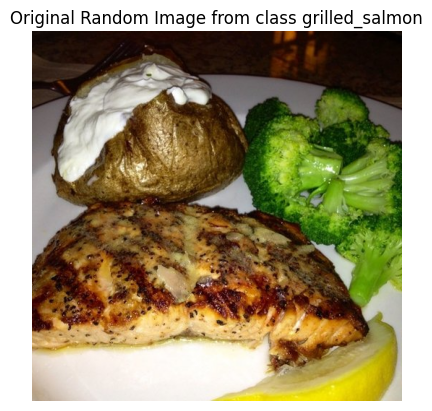

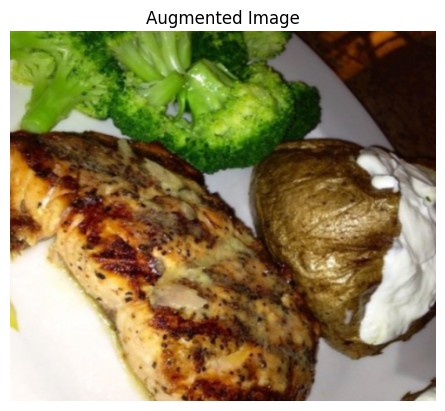

In [ ]:
# Visualize our Data Augmentation Layer
# View a Random Image and Compare it our Augmented Image
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a random class
target_class = random.choice(train_data_1_percent.class_names)
# Set the directory to the found class
target_dir = "10_food_classes_1_percent/train/" + target_class
# Pick an image from the directory and create the path of the image along with image name
random_image = target_dir + "/" + random.choice(os.listdir(target_dir))
# Plot the image
img = mpimg.imread(random_image)
plt.imshow(img)
plt.title(f"Original Random Image from class {target_class}")
plt.axis(False)

# Lets plot augmented image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented Image")
plt.axis(False)

### Create Compile Fit Model 1

In [ ]:
import tensorflow as tf
input_shape = (224,224,3)

# Create the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Trainable
base_model.trainable = False

# Inputs
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Data Augmentation Seq Model as Layer
x = data_augmentation(inputs)

# Pass the inputs
x = base_model(x, training=False)

# GlobalAvP2D
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Pass Inputs and Outputs to Model
model_1 = keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20251024-190603
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0819 - loss: 2.5253 - val_accuracy: 0.1414 - val_loss: 2.2949
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step - accuracy: 0.1574 - loss: 2.2814 - val_accuracy: 0.2089 - val_loss: 2.1720
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step - accuracy: 0.3362 - loss: 2.0515 - val_accuracy: 0.3076 - val_loss: 2.0725
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.3472 - loss: 1.9393 - val_accuracy: 0.3717 - val_loss: 1.9702
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 0.6054 - loss: 1.7863 - val_accuracy: 0.4408 - val_loss: 1.8724


In [ ]:
# Summary
model_1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [ ]:
# Evaluate on Full Test Set
model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4236 - loss: 1.8863


[1.8931570053100586, 0.4203999936580658]

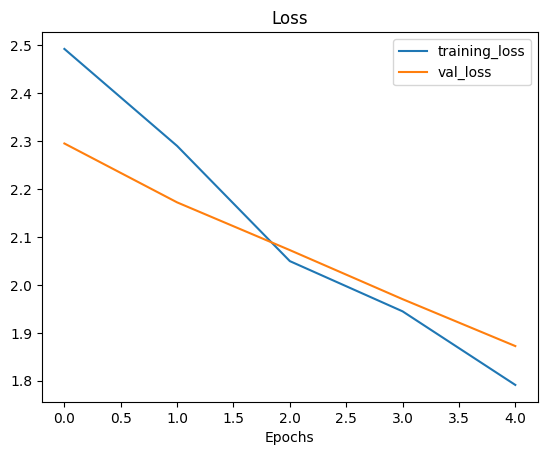

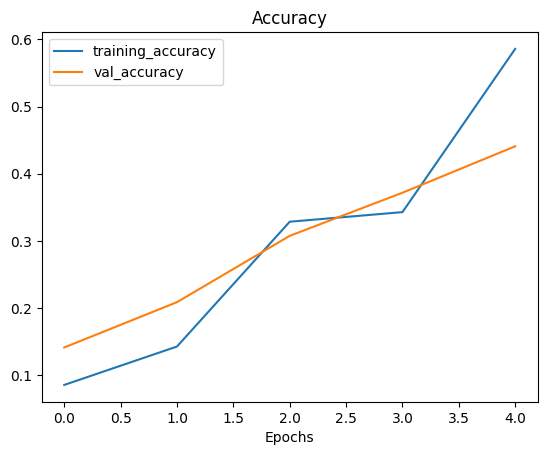

In [ ]:
# Plot
plot_loss_curves(history_1_percent)

## Model 2 - Feature Extraction + 10% data + Aug

### Prep Datasets

In [ ]:
# We already downloaded data, we just need to define directories
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Train Dataset
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
#Test Dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Data Augmentation (same as above model)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
], name="data_augmentation")

### Create and Compile

✅ Training = false when calling the base model with augmented data is given to make sure that the base model is used only in inference mode and no updates are made to the Batch Normalization Statistics Layer in the Base Model

In [ ]:
import tensorflow as tf
input_shape = (224,224,3)

# Create a Frozen Base Model(also called Backbone Model)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable =  False
# Create Inputs and Outputs
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)# False ensures that the base model is being called for inferences only and no updates are made
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs,outputs)
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Callback : Model Checkpoint
ModelCheckpoint callback intermediately saves the model during training.

Parameters
1. monitor : the parameter given to this parameter will be monitored and make checkpoints based on it. Default is val_loss

2. save_best_only : used in conjunction with monitor. It will monitor the val_loss and saved the epoch which has the lowest val_loss. it saves the lowest because we have save_best_only by default as False. if we set to true, the epoch with best val_loss will be saved

3. save_weights : if set to true only the model's weights will be saved, if not the whole model will be saved

4. save_freq : number of epochs for which the save needs to be happen

In [ ]:
# Set checkpoint path. if we do not provide a path, a default one will be created
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.weights.h5"

# Create ModelCheckpoint Callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq="epoch")

### Fit the Model with callbacks

In [ ]:
# Set initial epochs to 5. Later in down models, we can fine tune for additional 5 epochs
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="model_2"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2/20251027-121920
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.2487 - loss: 2.1094
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - accuracy: 0.2534 - loss: 2.1029 - val_accuracy: 0.5740 - val_loss: 1.4937
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6363 - loss: 1.4258
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.6363 - loss: 1.4237 - val_accuracy: 0.7286 - val_loss: 1.0917
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7352 - loss: 1.1061
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.7346 - loss: 1.1062 - val_accuracy: 0.7878 - val_loss: 0.8557
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7

### Model 0 vs Model 2
Model 0 - Feature Extraction Model with 10 percent Data.

Model 2 - Feature Extraction Model with 10 percent Data + Data Augmentation

Looks like without Augmentation, the Model 0 performs slightly better

In [ ]:
result_10_percent_data = model_0.evaluate(test_data)

NameError: name 'model_0' is not defined

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8157 - loss: 0.6701


Plot Loss Curves - Model 2

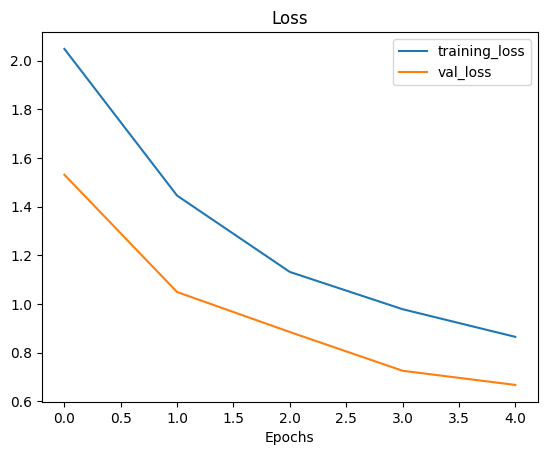

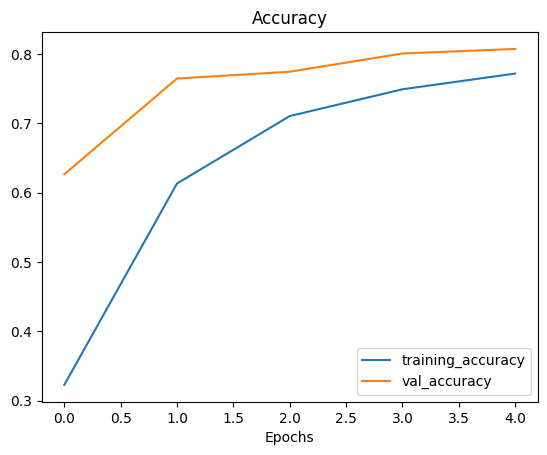

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Load Model Weights back to Model 2
We had saved Model 2 weights. Lets load them back to Model 2 and evaluate the model

In [ ]:
# Load
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8203 - loss: 0.6625


In [ ]:
results_10_percent_data_aug, loaded_weights_model_results

NameError: name 'results_10_percent_data_aug' is not defined

There might be minute differences, hence we can check using isclose command

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

Showing up as same, only with minute minute difference which is ok, due to precision of storage

In [ ]:
print(np.array(loaded_weights_model_results) - np.array(results_10_percent_data_aug))

[-1.78813934e-07  0.00000000e+00]


## Model 3 : Transfer Learning + Fine Tuning

When Fine tuning the base model, we fine tune the layers towards the end mostly, towards the output layer. This is because, the initial set of layers would have learnt the more general features.

Ones close to the output would have learnt the minute features and hence we can fine tune them.\

✅**Note:** Fine tuning usually works best after training a feature extraction model for few epochs with large amounts of custom data. After just doing feature extraction, do some training on custom large data. After that if we fine tune it works best

### Model 2 Layers Understannding

In [ ]:
# Model 3 is basically the same Model 2 with some fine tuning. To fine tune, we need to
# check which layers in Module 2 are trainable
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Layers in Model 2
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [ ]:
# Check trainable status
for layer in model_2.layers:
  print(f"Layer Name : {layer}, Trainable Status : {layer.trainable}")

Layer Name : <InputLayer name=input_layer, built=True>, Trainable Status : True
Layer Name : <Sequential name=data_augmentation, built=True>, Trainable Status : True
Layer Name : <Functional name=efficientnetv2-b0, built=True>, Trainable Status : False
Layer Name : <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>, Trainable Status : True
Layer Name : <Dense name=output_layer, built=True>, Trainable Status : True


In [ ]:
# Lets deep dive into the Layer 2 - efficientnet Layer and see their layers inside
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_layer_13 False
1 rescaling_9 False
2 normalization_9 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_d

In [ ]:
# How many trainable variables in our base mode
print(len(model_2.layers[2].trainable_variables))

0


### Fine Tuning Begins
Lets fine tune base_model, by setting the last 10 layers of our base model with trainable = True

Lets loop through the layers

In [ ]:
# First lets set all layers trainable to True
base_model.trainable = True

In [ ]:
# Let see through layers now
for i, layer in enumerate (model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

Now all layers are trainable. We need only the last 10 layers as trainable, the remaining False

In [ ]:
for i, layer in enumerate(base_model.layers):
  print (i, layer.name, layer.trainable)

0 input_layer True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

In [ ]:
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
  print (i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
print (len(model_2.trainable_variables))

12


### Recompile Model 2

When we fine tune an existing model, we need to make sure that the ***LEARNING RATE is DECREASED by 10x*** usually. This will make sure that there will not be much of a disturbance to the weights/ patterns which the model had already learnt

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

### Refit Model 2 with additional epochs (5 to 10)

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# We are give "INITIAL EPOCH" (TO START TRAINING FROM WHERE IT LEFT OFF)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               steps_per_epoch = len(train_data_10_percent),
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="model_3")])

Saving TensorBoard log files to: transfer_learning/model_3/20251027-122058
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 426ms/step - accuracy: 0.7427 - loss: 1.0292 - val_accuracy: 0.8092 - val_loss: 0.7244
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.8047 - loss: 0.8781 - val_accuracy: 0.8273 - val_loss: 0.6372
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8157 - loss: 0.8044 - val_accuracy: 0.8438 - val_loss: 0.6007
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8334 - loss: 0.7453 - val_accuracy: 0.8355 - val_loss: 0.5629
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8065 - loss: 0.7259 - val_accuracy: 0.8487 - val_loss: 0.5158
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8060 - loss: 0.7067 - val_accuracy: 0.8553 - val_loss: 0.5103


In [ ]:
history_10_percent_data_aug.epoch

[0, 1, 2, 3, 4]

In [ ]:
# Evaluate Fine Tuned Model 2
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8366 - loss: 0.5158


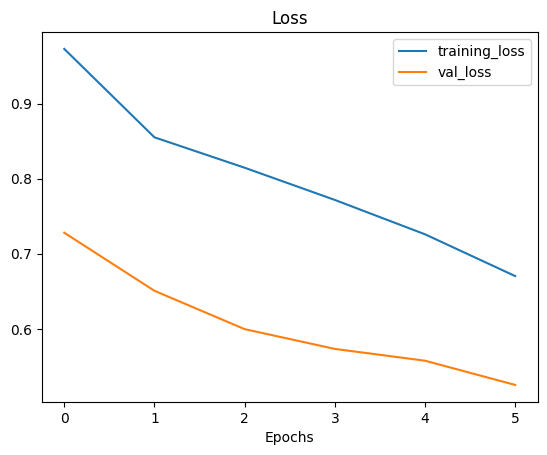

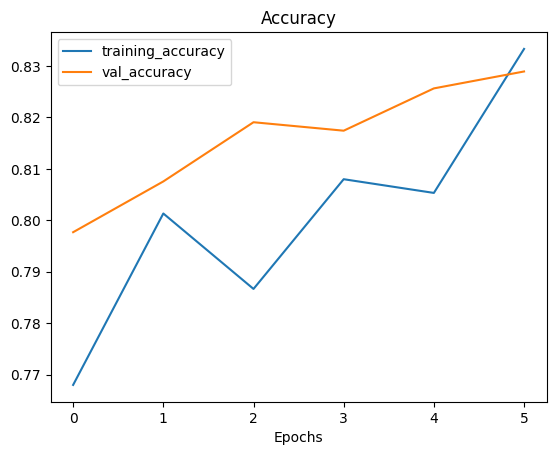

In [ ]:
# Plot Loss Curves
plot_loss_curves(history_fine_10_percent_data_aug)

The plot loss curves works for models which has been fit only once. We need a new function, which compares before and after fine tuning

### Plot Loss Curves Orig vs Fine Tuned

In [ ]:
# Function to plot curves between original and fine tuned models

def compare_orig_finetune(original_history, finetune_history, initial_epochs=5):
  # Get the loss and accuracy from Orig
  loss = original_history.history["loss"]
  accuracy = original_history.history["accuracy"]

  val_loss = original_history.history["val_loss"]
  val_accuracy = original_history.history["val_accuracy"]

  print(loss, accuracy, val_loss, val_accuracy)
  # Fine tuned values
  total_loss = loss + finetune_history.history["loss"]
  total_accuracy = accuracy + finetune_history.history["accuracy"]

  total_val_loss = val_loss + finetune_history.history["val_loss"]
  total_val_accuracy = val_accuracy + finetune_history.history["val_accuracy"]

  import matplotlib.pyplot as plt

  # Plot
  plt.figure(figsize=(8,8))

  plt.subplot(2,1,1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.title("Loss Curve")
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(total_accuracy, label="Training Accuracy")
  plt.plot(total_val_accuracy, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.title("Accuracy Curve")
  plt.legend(loc="lower right")

[1.9468547105789185, 1.3746936321258545, 1.1087496280670166, 0.940653383731842, 0.8541692495346069] [0.36399999260902405, 0.637333333492279, 0.7200000286102295, 0.7599999904632568, 0.7760000228881836] [1.4936909675598145, 1.0916595458984375, 0.8557432293891907, 0.7256714105606079, 0.6344239115715027] [0.5740131735801697, 0.7286184430122375, 0.7878289222717285, 0.8157894611358643, 0.8273026347160339]


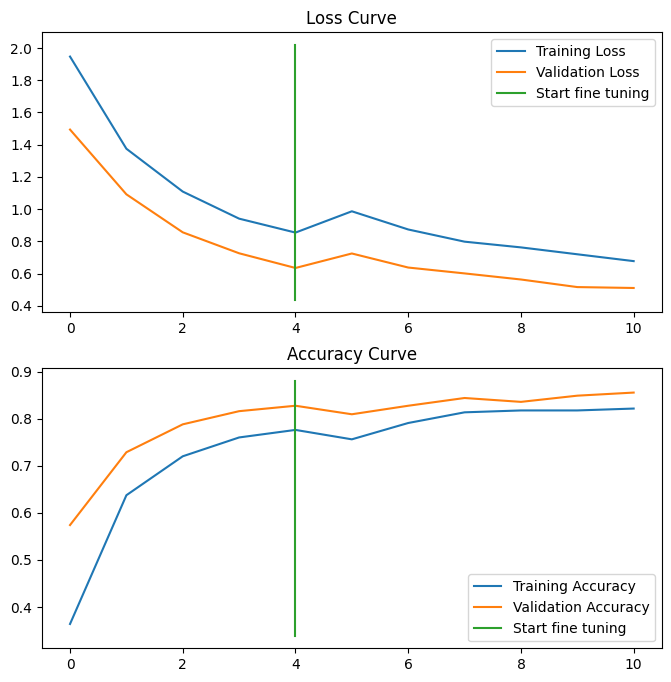

In [ ]:
compare_orig_finetune(history_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4 : Fine tuning + all data

To achieve this, let's use Model 2 which is the feature extraction model, load the weights, make sure that the top 10 layers are trainable - recompile, fit with 100% data

### Prep Datasets

In [ ]:
# Get Data
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
# Unzip
unzip_data("10_food_classes_all_data.zip")
# Look at files
walk_through_dir("10_food_classes_all_data")

--2025-10-27 13:07:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  21.0MB/s    in 24s     

2025-10-27 13:07:53 (20.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_da

In [ ]:
# Set up directories
train_dir_100_percent = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

# Prepare training datasets
train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_100_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical")
# Prepare testing datasets
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# # Create base model
# base_model = tf.keras.application.EfficientNetV2B0.efficientnet_v2(on_top=False)
# base_model.trainable = False

# #inputs
# inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
# # Data Augmentation
# x = data_augmentation(inputs)
# # Pass the inputs to base model
# x = base_model(x, training=False)
# # Glob Avg 2D
# x = tf.keras.layers.GlobalAveragePooling2D(name="glob_avg_pool_2d")(x)
# # output
# outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
# # create model
# model_3 = tf.keras.Model(inputs, outputs)

### Restore Weights and Recompile



In [ ]:
# Restore Weights
model_2.load_weights(checkpoint_path)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Check Model Summary if trainable layers are present or not
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,121,104 (27.16 MB)

 Trainable params: 594,490 (2.27 MB)

 Non-trainable params: 5,337,632 (20.36 MB)

 Optimizer params: 1,188,982 (4.54 MB)

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer, layer.trainable)

0 <InputLayer name=input_layer, built=True> True
1 <Sequential name=data_augmentation, built=True> True
2 <Functional name=efficientnetv2-b0, built=True> True
3 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
4 <Dense name=output_layer, built=True> True


In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <InputLayer name=input_layer, built=True> False
1 <Rescaling name=rescaling, built=True> False
2 <Normalization name=normalization, built=True> False
3 <Conv2D name=stem_conv, built=True> False
4 <BatchNormalization name=stem_bn, built=True> False
5 <Activation name=stem_activation, built=True> False
6 <Conv2D name=block1a_project_conv, built=True> False
7 <BatchNormalization name=block1a_project_bn, built=True> False
8 <Activation name=block1a_project_activation, built=True> False
9 <Conv2D name=block2a_expand_conv, built=True> False
10 <BatchNormalization name=block2a_expand_bn, built=True> False
11 <Activation name=block2a_expand_activation, built=True> False
12 <Conv2D name=block2a_project_conv, built=True> False
13 <BatchNormalization name=block2a_project_bn, built=True> False
14 <Conv2D name=block2b_expand_conv, built=True> False
15 <BatchNormalization name=block2b_expand_bn, built=True> False
16 <Activation name=block2b_expand_activation, built=True> False
17 <Conv2D name=bloc

In [ ]:
# Recompile Model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

### Fit with 100 Percent Data

In [ ]:
# Set Fine Tune Epochs
initial_epochs=5
fine_tune_epochs = initial_epochs+5

# Fit
history_fine_100_percent_data_aug = model_2.fit(train_data_100_percent,
                                                epochs=fine_tune_epochs,
                                                steps_per_epoch=len(train_data_100_percent),
                                                validation_data=test_data,
                                                validation_steps=int(0.25 * len(test_data)),
                                                initial_epoch=history_10_percent_data_aug.epoch[-1],
                                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="model_4")])

Saving TensorBoard log files to: transfer_learning/model_4/20251027-133017
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 70s 241ms/step - accuracy: 0.7196 - loss: 0.9878 - val_accuracy: 0.8701 - val_loss: 0.4214
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.7821 - loss: 0.7209 - val_accuracy: 0.9030 - val_loss: 0.3305
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.8075 - loss: 0.6383 - val_accuracy: 0.9079 - val_loss: 0.3022
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.8145 - loss: 0.5875 - val_accuracy: 0.9095 - val_loss: 0.2743
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.8331 - loss: 0.5344 - val_accuracy: 0.9227 - val_loss: 0.2596
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.8320 - loss: 0.5189 - val_accuracy: 0.9243 - val_loss: 0.2490


In [ ]:
# Evaluate
model_2.evaluate(train_data_100_percent)

235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8956 - loss: 0.3305


[0.3279256224632263, 0.8967999815940857]

[1.9468547105789185, 1.3746936321258545, 1.1087496280670166, 0.940653383731842, 0.8541692495346069] [0.36399999260902405, 0.637333333492279, 0.7200000286102295, 0.7599999904632568, 0.7760000228881836] [1.4936909675598145, 1.0916595458984375, 0.8557432293891907, 0.7256714105606079, 0.6344239115715027] [0.5740131735801697, 0.7286184430122375, 0.7878289222717285, 0.8157894611358643, 0.8273026347160339]


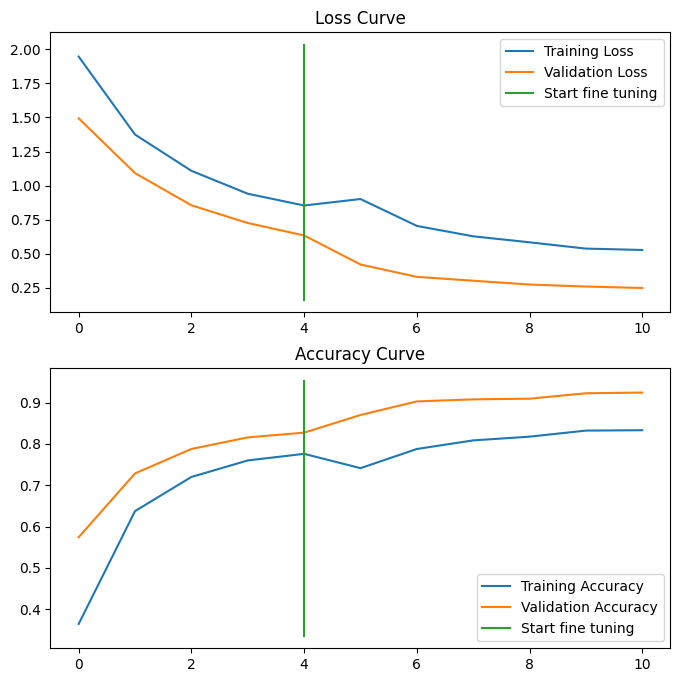

In [ ]:
# Plot
compare_orig_finetune(history_10_percent_data_aug, history_fine_100_percent_data_aug)

## View Results on TensorBoard

Tensorboard Dev was shutdown eff Jan 2024

In [ ]:
# # View tensorboard logs
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer Learning Experiements" \
#   --description "Feature Ext vs 10 Percent vs 100 Percent" \
#   --one_shot

2025-10-27 13:56:28.709610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761573388.731322   28739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761573388.737810   28739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761573388.754253   28739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761573388.754296   28739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761573388.754299   28739 computation_placer.cc:177] computation placer alr